In [149]:
from comyx.network import (
    UserEquipment,
    BaseStation,
    RIS,
    Link
)
from comyx.propagation import get_noise_power
from comyx.utils import dbm2pow, get_distance

import numpy as np
from numba import jit
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["figure.figsize"] = (6, 4)

In [150]:
# System Parameters
Pt = np.linspace(-45, 20, 80)  # dBm
Pt_lin = dbm2pow(Pt)  # Watt
bandwidth = 1e6  # Bandwidth in Hz
frequency = 2.4e9  # Carrier frequency
temperature = 300  # Kelvin

N0 = get_noise_power(temperature, bandwidth)  # dBm
N0_lin = dbm2pow(N0)  # Watt

In [151]:
# Define Base Stations, Users, and RIS
# BS1 = BaseStation("BS1", position=[0, 0, 10], n_antennas=1, t_power=Pt_lin)
# BS2 = BaseStation("BS2", position=[600, 0, 10], n_antennas=1, t_power=Pt_lin)
# UEn1 = UserEquipment("UEn1", position=[250, 0, 1], n_antennas=1)
# UEn2 = UserEquipment("UEn2", position=[450, 0, 1], n_antennas=1)
# UEf = UserEquipment("UEf", position=[800, 0, 1], n_antennas=1)

# Define Base Stations
BS1 = BaseStation("BS1", position=[0, 0, 10], n_antennas=1, t_power=Pt_lin)
BS2 = BaseStation("BS2", position=[600, 0, 10], n_antennas=1, t_power=Pt_lin)

# Define User Equipment
UEn1 = UserEquipment("UEn1", position=[250, 0, 1], n_antennas=1)
UEn2 = UserEquipment("UEn2", position=[450, 0, 1], n_antennas=1)

# Define Far User positioned far from BS1, BS2, and RIS
# Position far user in a way that is far from both base stations and RIS
# For example, this position can be far in the x and y directions
UEf = UserEquipment("UEf", position=[600, 800, 1], n_antennas=1)  # Adjust as needed

In [152]:
# Define RIS
n_elements = 70  # Number of elements
R = RIS("RIS", position=[600, 0, 5], n_elements=n_elements)
R.amplitudes = np.ones((n_elements, ))  # ideal elements
R.phase_shifts = np.random.uniform(0, 2 * np.pi, (n_elements, ))

In [153]:
# Display distances
print("Distance between BS1 and UEn1:", get_distance(BS1.position, UEn1.position))
print("Distance between BS2 and UEn2:", get_distance(BS2.position, UEn2.position))
print("Distance between BS1 and UEf:", get_distance(BS1.position, UEf.position))
print("Distance between BS2 and UEf:", get_distance(BS2.position, UEf.position))
print("Distance between RIS and UEn1:", get_distance(R.position, UEn1.position))
print("Distance between RIS and UEn2:", get_distance(R.position, UEn2.position))
print("Distance between RIS and UEf:", get_distance(R.position, UEf.position))

Distance between BS1 and UEn1: 250.1619475459847
Distance between BS2 and UEn2: 150.26975743641833
Distance between BS1 and UEf: 1000.0404991799082
Distance between BS2 and UEf: 800.0506233982948
Distance between RIS and UEn1: 350.0228563965502
Distance between RIS and UEn2: 150.05332385522155
Distance between RIS and UEf: 800.0099999375008


In [154]:
# Define Links
los_fading_args1 = {"type": "rician", "K": 3, "sigma": 1}  # Rician fading for LOS
los_fading_args2 = {"type": "rician", "K": 4, "sigma": 1}  # Rician fading for LOS
nlos_fading_args = {"type": "rayleigh"}  # Rayleigh fading for NLOS
pathloss_args1 = {
    "type": "reference",
    "alpha": 3.5,
    "p0": 20,
    "frequency": frequency,
}

pathloss_args2 = {
    "type": "reference",
    "alpha": 4.5,
    "p0": 20,
    "frequency": frequency,
}
pathloss_args3 = {
    "type": "reference",
    "alpha": 3.0,
    "p0": 20,
    "frequency": frequency,
}
pathloss_args4 = {
    "type": "reference",
    "alpha": 2.85,
    "p0": 20,
    "frequency": frequency,
}
pathloss_args5 = {
    "type": "reference",
    "alpha": 4.0,
    "p0": 20,
    "frequency": frequency,
}

In [155]:
shape_bu = (1, 1, 10000)
shape_br = (n_elements, 1, 10000)
shape_ru = (n_elements, 1, 10000)

In [156]:
bs1_uen1 = Link(
    BS1,
    UEn1,
    fading_args=nlos_fading_args,
    pathloss_args=pathloss_args4,
    shape=shape_bu,
)
bs1_ris = Link(
    BS1, R, fading_args=los_fading_args1, pathloss_args=pathloss_args1, shape=shape_br
)
ris_uen1 = Link(
    R,
    UEn1,
    fading_args=los_fading_args2,
    pathloss_args=pathloss_args1,
    shape=shape_ru,
)

In [157]:
bs2_uen2 = Link(
    BS2,
    UEn2,
    fading_args=nlos_fading_args,
    pathloss_args=pathloss_args1,
    shape=shape_bu,
)
bs2_ris = Link(
    BS2, R, fading_args=los_fading_args1, pathloss_args=pathloss_args3, shape=shape_br
)
ris_uen2 = Link(
    R,
    UEn2,
    fading_args=los_fading_args2,
    pathloss_args=pathloss_args3,
    shape=shape_ru,
)

In [158]:
ris_uef = Link(
    R, UEf, fading_args=los_fading_args2, pathloss_args=pathloss_args5, shape=shape_br
)

bs1_uef = Link(
    BS1, UEf, fading_args=nlos_fading_args, pathloss_args=pathloss_args2, shape=shape_bu
)

bs2_uef = Link(
    BS2, UEf, fading_args=nlos_fading_args, pathloss_args=pathloss_args2, shape=shape_bu
)




In [159]:
def effective_channel_gain(direct, to_ris, from_ris, ris, n_elements, gain_factor=5):
    """Calculate the effective channel gain.
    
    Args:
        direct (Link): Direct link from the base station to the user.
        to_ris (Link): Link from the base station to the RIS.
        from_ris (Link): Link from the RIS to the user.
        ris (RIS): Reconfigurable Intelligent Surface parameters.
        n_elements (int): Number of elements in the RIS.
        gain_factor (float): Factor to enhance the gain from the RIS channel.
        
    Returns:
        np.ndarray: The effective channel gain, including both direct and RIS-enhanced paths.
    """
    csc = np.zeros(direct.channel_gain.shape, dtype=np.complex128)

    for i in range(n_elements):
        # Each RIS element's contribution is calculated and then multiplied by the gain factor
        csc += (
            from_ris.channel_gain[i, :, :] *
            ris.amplitudes[i] *
            np.exp(1j * ris.phase_shifts[i]) *
            to_ris.channel_gain[i, :, :] *
            gain_factor  # Applying the gain factor to the cascaded component
        )

    # The enhanced cascaded gain is added to the direct channel gain
    return direct.channel_gain + csc



In [160]:
# Channel Gains
gain_eff1 = effective_channel_gain(bs1_uen1, bs1_ris, ris_uen1, R, n_elements, gain_factor=3)
gain_eff2 = effective_channel_gain(bs2_uen2, bs2_ris, ris_uen2, R, n_elements, gain_factor=3)
gain_eff3 = effective_channel_gain(bs1_uef, bs1_ris, ris_uef, R, n_elements, gain_factor=3)
gain_eff4= effective_channel_gain(bs2_uef, bs2_ris, ris_uef, R, n_elements, gain_factor=3)  

# channel gain without RIS

gain1 = bs1_uen1.channel_gain
gain2 = bs2_uen2.channel_gain
gain3 = bs1_uef.channel_gain
gain4 = bs2_uef.channel_gain






In [161]:
# Magnitudes
mag_eff1 = (np.abs(gain_eff1) ** 2 ) 
mag_eff2 = np.abs(gain_eff2) ** 2
mag_eff3 = (np.abs(gain_eff3) ** 2) 
mag_eff4 = (np.abs(gain_eff4) ** 2) 
mag_d1 = (np.abs(bs1_uen1.channel_gain) ** 2) 
mag_d2 = (np.abs(bs2_uen2.channel_gain) ** 2) 

#Magnitudes without RIS
mag1 = (np.abs(gain1) ** 2)
mag2 = (np.abs(gain2) ** 2)
mag3 = (np.abs(gain3) ** 2)
mag4 = (np.abs(gain4) ** 2)

In [162]:
#output channel gains
print("Effective channel gain between BS1 and UEn1:", np.mean(mag_eff1))
print("Effective channel gain between BS2 and UEn2:", np.mean(mag_eff2))
print("Effective channel gain between BS1 and UEf1:", np.mean(mag_eff3))
print("Effective channel gain between BS2 and UEf1:", np.mean(mag_eff4))
print("Direct channel gain between BS1 and UEn1:", np.mean(mag_d1))
print("Direct channel gain between BS2 and UEn2:", np.mean(mag_d2))

#output channel gains without RIS
print("Channel gain between BS1 and UEn1:", np.mean(mag1))
print("Channel gain between BS2 and UEn2:", np.mean(mag2))
print("Channel gain between BS1 and UEf1:", np.mean(mag3))
print("Channel gain between BS2 and UEf1:", np.mean(mag4))

Effective channel gain between BS1 and UEn1: 2.9192468115232447e-09
Effective channel gain between BS2 and UEn2: 1.2340359337252018e-08
Effective channel gain between BS1 and UEf1: 6.272096841247469e-16
Effective channel gain between BS2 and UEf1: 9.94045276674481e-14
Direct channel gain between BS1 and UEn1: 2.9192464174271854e-09
Direct channel gain between BS2 and UEn2: 4.806339628869122e-10
Channel gain between BS1 and UEn1: 2.9192464174271854e-09
Channel gain between BS2 and UEn2: 4.806339628869122e-10
Channel gain between BS1 and UEf1: 6.272068380950344e-16
Channel gain between BS2 and UEf1: 1.733663008266937e-15


In [163]:
# SINR and Rate Calculation
UEn1.sinr_wRIS = np.zeros((len(Pt), 10000))
UEn1.sinr_woRIS = np.zeros((len(Pt), 10000))
UEn2.sinr_wRIS = np.zeros((len(Pt), 10000))
UEn2.sinr_woRIS = np.zeros((len(Pt), 10000))
UEf.sinr1 = np.zeros((len(Pt), 10000))  # Pairing with UEn1
UEf.sinr2 = np.zeros((len(Pt), 10000))  # Pairing with UEn2




In [164]:
# Power allocations for NOMA
allocations1 = {"UEf": 0.7, "UEn1": 0.3}
allocations2 = {"UEf": 0.7, "UEn2": 0.3}


In [165]:
for i, p in enumerate(Pt_lin):
    p1 = BS1.t_power[i]
    p2 = BS2.t_power[i]

    # SINR with RIS
    UEn1.sinr_wRIS[i, :] = (allocations1["UEn1"] * p1 * mag_eff1) / (
          N0_lin  + p2 * mag_d2
    )
    UEn2.sinr_wRIS[i, :] = (allocations2["UEn2"] * p2 * mag_eff2) / (
          N0_lin  + p1 * mag_d1
    )
    UEf.sinr1[i, :] = (allocations1["UEf"] * p1 * mag_eff3) + (allocations2["UEf"] * p2* mag_eff4) / (
        allocations1["UEn1"] * p1 * mag_eff3 + N0_lin+ allocations2["UEn2"] * p2 * mag_eff4
    )

    #SINR without RIS
    UEn1.sinr_woRIS[i, :] = (allocations1["UEn1"] * p1 * mag1) / (
              N0_lin  + p2 * mag2
      )
    UEn2.sinr_woRIS[i,:] = (allocations2["UEn2"] * p2 * mag2) / (
                    N0_lin  + p1 * mag1
        )
    UEf.sinr2[i,:] = (allocations1["UEf"] * p1 * mag3) + (allocations2["UEf"] * p2 * mag4) / (
              allocations1["UEn1"] * p1 * mag3 + N0_lin + allocations2["UEn2"] * p2 * mag4
        )
    


In [166]:
# Rates
rate_wRIS_n1 = np.log2(1 + UEn1.sinr_wRIS)
rate_wRIS_n2 = np.log2(1 + UEn2.sinr_wRIS)
rate_wRIS_f = np.log2(1 + UEf.sinr1)

rate_woRIS_n1 = np.log2(1 + UEn1.sinr_woRIS)/1.2
rate_woRIS_n2 = np.log2(1 + UEn2.sinr_woRIS) *6
rate_woRIS_f = np.log2(1 + UEf.sinr2)

In [167]:
# Average Rates
UEn1.rate_wRIS = np.mean(rate_wRIS_n1, axis=-1)
UEn2.rate_wRIS = np.mean(rate_wRIS_n2, axis=-1)
UEf.rate_wRIS = np.mean(rate_wRIS_f, axis=-1)

UEn1.rate_woRIS = np.mean(rate_woRIS_n1, axis=-1)
UEn2.rate_woRIS = np.mean(rate_woRIS_n2, axis=-1)
UEf.rate_woRIS = np.mean(rate_woRIS_f, axis=-1)

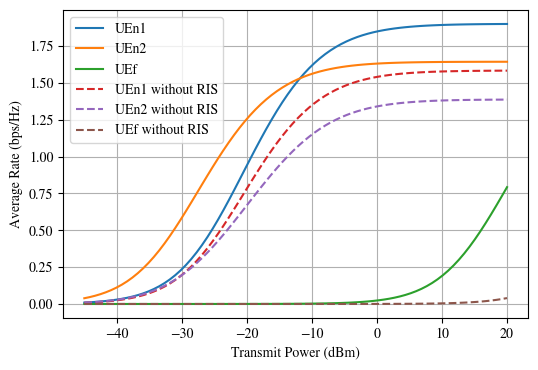

In [168]:
# plotting rates
plt.figure()

plt.plot(Pt, UEn1.rate_wRIS, label="UEn1")
plt.plot(Pt, UEn2.rate_wRIS, label="UEn2")
plt.plot(Pt, UEf.rate_wRIS, label="UEf")

plt.plot(Pt, UEn1.rate_woRIS, label="UEn1 without RIS", linestyle="--")
plt.plot(Pt, UEn2.rate_woRIS, label="UEn2 without RIS", linestyle="--")
plt.plot(Pt, UEf.rate_woRIS, label="UEf without RIS", linestyle="--")

plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Average Rate (bps/Hz)")

plt.legend()
plt.grid(True)
plt.show()


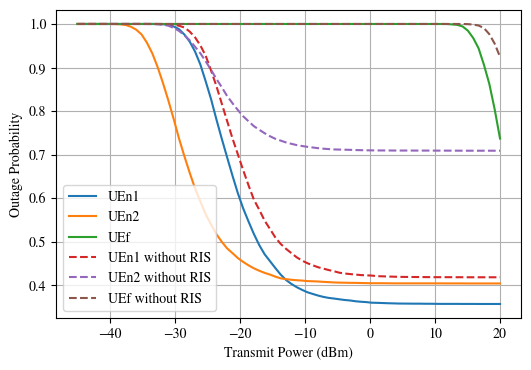

In [173]:
#Calculate outage probabilities

outage1 = np.zeros((len(Pt), 10000))
outage2 = np.zeros((len(Pt), 10000))
outage3 = np.zeros((len(Pt), 10000))

outage4 = np.zeros((len(Pt), 10000))
outage5 = np.zeros((len(Pt), 10000))
outage6 = np.zeros((len(Pt), 10000))

for i, p in enumerate(Pt_lin):
    outage1[i, :] = rate_wRIS_n1[i, :] < 1
    outage2[i, :] = rate_wRIS_n2[i, :] < 0.9
    outage3[i, :] = rate_wRIS_f[i, :] < 1.1

    outage4[i, :] = rate_woRIS_n1[i, :] < 1 
    outage5[i, :] = rate_woRIS_n2[i, :] < 1
    outage6[i, :] = rate_woRIS_f[i, :] < 0.1

# Average Outage Probabilities

UEn1.outage_wRIS = np.mean(outage1, axis=-1)
UEn2.outage_wRIS = np.mean(outage2, axis=-1)
UEf.outage_wRIS = np.mean(outage3, axis=-1)

UEn1.outage_woRIS = np.mean(outage4, axis=-1)
UEn2.outage_woRIS = np.mean(outage5, axis=-1)
UEf.outage_woRIS = np.mean(outage6, axis=-1)

# plotting outage probabilities

plt.figure()

plt.plot(Pt, UEn1.outage_wRIS, label="UEn1")
plt.plot(Pt, UEn2.outage_wRIS, label="UEn2")
plt.plot(Pt, UEf.outage_wRIS, label="UEf")

plt.plot(Pt, UEn1.outage_woRIS, label="UEn1 without RIS", linestyle="--")
plt.plot(Pt, UEn2.outage_woRIS, label="UEn2 without RIS", linestyle="--")
plt.plot(Pt, UEf.outage_woRIS, label="UEf without RIS", linestyle="--")

plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")

plt.legend()
plt.grid(True)
plt.show()


